<a href="https://colab.research.google.com/github/romenlaw/NaiveNeuralNetwork/blob/main/makemore_backprop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Makemore - backprop ninja

## prepare datasets

In [1]:
!curl -O https://raw.githubusercontent.com/romenlaw/NaiveNeuralNetwork/main/names.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  222k  100  222k    0     0   996k      0 --:--:-- --:--:-- --:--:--  999k


In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open('names.txt', 'r').read().splitlines()
len(words), max(len(w) for w in words), words[:8]

(32033,
 15,
 ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia'])

In [4]:
vocab = sorted(list(set(''.join(words))))
vocab.insert(0, '.')
itos = { i:s for i,s in enumerate(vocab)}
stoi = { s:i for i,s in enumerate(vocab)}
vocab_size = len(vocab)  # 27

In [5]:
block_size = 3  # context size - 3 tokens

def build_dataset(words):
  """returns torch tensors X, Y where
  X is a list of n-grams indices covering the whole words list, where n=block_size
  Y is a list of indices predicting each n-gram in X
  """
  X, Y = [], []

  #for w in words[:5]:
  for w in words:
    context = [0] * block_size # repeat '.' to fill block_size
    for ch in w+'.':
      ix = stoi[ch]
      #print(' '.join([itos[i] for i in context]), '---->', itos[ix])
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]

  return torch.tensor(X), torch.tensor(Y)

X, Y = build_dataset(words)
#X[:32], Y[:32]

# split the data into 3 sets
# 80% for training set
# 10% for validation/development
# 10% for testing
import random
random.seed(42)
n1 = int(len(words) * .8)
n2 = int(len(words) * .9)
random.shuffle(words) # shuffle is in-place
X_train, Y_train = build_dataset(words[:n1])
X_dev, Y_dev = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

#len(words[n1:n2])
(X_train.shape, Y_train.shape), (X_dev.shape, Y_dev.shape), (X_test.shape, Y_test.shape)

((torch.Size([182625, 3]), torch.Size([182625])),
 (torch.Size([22655, 3]), torch.Size([22655])),
 (torch.Size([22866, 3]), torch.Size([22866])))

## utilities

In [6]:
# utility to compare our manual gradients with pytorch gradients
def cmp(s, dt, t):
  """Compares dt and t.grad to see if their values are equal or close
  s - name of the parameter being compared, used in printing only
  dt - tensor of manually calculated gradient
  t - torch tensor
  """
  ex = torch.all(dt==t.grad).item()
  apx = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approx: {str(apx):5s} | maxdiff: {maxdiff}')

## MLP
In the parameter initialisation, we use non-standard values to see their effect; otherwise, for example, zeros can mask out any incorrect values.

In [7]:
embed_dim = 10
hidden_dim = 200

g = torch.Generator().manual_seed(20240824)
C = torch.randn((vocab_size, embed_dim),  generator=g)

# hidden layer
fan_in = embed_dim*block_size # we concat multiple C's to feed into hidden layer
W1 = torch.randn((fan_in, hidden_dim), generator=g) * (5/3 / fan_in**0.5)
b1 = torch.randn(hidden_dim,           generator=g) * 0.1 # experiment
# output layer
W2 = torch.randn((hidden_dim, vocab_size), generator=g) * 0.1
b2 = torch.randn(vocab_size,               generator=g) * 0.1 # experiment with non-zero

# batch normalisation 1D layer placed after hidden layer, hence dim=hidden_dim
bn_gamma = torch.randn((1, hidden_dim),    generator=g) * 0.1 + 1.0
bn_bias = torch.randn((1, hidden_dim),     generator=g) * 0.1

# the above are initialised with non-standard values to magnify any incorrect values

parameters = [C, W1, b1, W2, b2, bn_gamma, bn_bias]
print('total params: ', sum([p.nelement() for p in parameters]))
for p in parameters:
  p.requires_grad = True

total params:  12297


# Exercise 1 - slow pass
This exercise breaks down the forward pass into atomic individual steps, then back prop each step.

## training - extended version
We expand the forward pass into step by step calculations so that we can manually calculate the gradient step by step as well. For Cross Entropy loss function, see [pyTorch doco](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss).

We don't call the loss.backward(). Instead, we will do it manually.

In [8]:
# understanding tensor.values, which only works on sparse tensor
t = torch.randn((2,3))
sparse_tensor = t.max(dim=1, keepdim=True)
t, '-----------', sparse_tensor, '------------', sparse_tensor.values

(tensor([[-2.7579, -0.3532,  0.5664],
         [-0.1045,  0.6642, -0.6702]]),
 '-----------',
 torch.return_types.max(
 values=tensor([[0.5664],
         [0.6642]]),
 indices=tensor([[2],
         [1]])),
 '------------',
 tensor([[0.5664],
         [0.6642]]))

In [9]:
batch_size = 32

# construct mini-batch:
# generate a list of random indices, length of list if batch_size
ix = torch.randint(low=0, high=X_train.shape[0], size=(batch_size,), generator=g)
xs = X_train[ix]  # (batch_size, block_size)
ys = Y_train[ix]  # (batch_size)

##################################
# forward pass (expanded version)
##################################
# embedding ---------------------------
emb = C[xs] # (batch_size, block_size, hidden_dim)
embcat = emb.view(emb.shape[0], -1)
# hidden layer ------------------------
h_prebn = embcat @ W1 + b1 # (batch_size, hidden_dim)
# BN layer (expended version) ----------------------------
#bn_mean = h_prebn.mean(dim=0, keepdim=True)
bn_mean = 1/batch_size*h_prebn.sum(dim=0, keepdim=True)
#bn_std = h_prebn.std(dim=0, keepdim=True)
bn_diff = (h_prebn - bn_mean)
bn_diff2 = bn_diff ** 2
bn_var = 1/(batch_size-1) * bn_diff2.sum(dim=0, keepdim=True) # Bessel's correction, divide by m-1 not m
bn_varinv = (bn_var + 1e-5)**-0.5  # 1/sqrt(var+eps)
x_hat = bn_diff * bn_varinv
h_preact = bn_gamma * x_hat + bn_bias
# Non-linearity ----------------------
h = torch.tanh(h_preact)  # (batch_size, hidden_dim)
# output layer -----------------------
logits = h @ W2 + b2 # (hidden_dim, vocab_size)
# loss function (extended version) ----------------------
#loss = F.cross_entropy(logits, ys)
logit_maxes = logits.max(dim=1, keepdim=True).values  # (hidden_dim, 1)
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()  # (batch_size, vocab_size)
counts_sum = counts.sum(dim=1, keepdim=True) # (batch_size, 1)
counts_sum_inv = counts_sum ** -1  # (batch_size, 1)
probs = counts * counts_sum_inv  # (batch_size, vocab_size)
logprobs = probs.log()   # (batch_size, vocab_size)
loss = -logprobs[range(batch_size), ys].mean()  # scalar

################
# backward pass
################
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts_sum_inv, counts_sum, counts,
          norm_logits, logit_maxes, logits,
          h, h_preact, x_hat, bn_varinv, bn_var, bn_diff2, bn_diff, bn_mean,
          h_prebn, embcat, emb ]:
  t.retain_grad()

loss.backward()

print('loss: %2.10f' % (loss))

loss: 3.5082895756


In [10]:
ys.shape

torch.Size([32])

## 1 - backward pass of loss function

### dlogprobs
logprobs is dimension (N, vocab_size) , where N = batch_size
$$loss = -\dfrac{1}{N}\sum_{i=1}^{N}logprobs_{i, y_i}$$
For the loss function, only elements at indices $[i, y_i]$ contribute to the loss. The rest are not used. Therefore, the unused elements have gradient 0.
$$\dfrac{\delta loss}{\delta logprobs}=
\begin{cases}
-\dfrac{1}{N} & \quad \text{at positions }{i},{y_i}\\
0 & \quad \text{elsewhere}
\end{cases}
$$

In [11]:
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(batch_size), ys] = -1/batch_size
cmp('dlogprobs', dlogprobs, logprobs)

dlogprobs       | exact: True  | approx: True  | maxdiff: 0.0


### dprobs
$$logprobs = \ln(probs)$$
$$\dfrac{\delta logprobs}{\delta probs} = \dfrac{1}{probs}
$$

In [12]:
dprobs = 1/probs * dlogprobs
cmp('dprobs', dprobs, probs)

dprobs          | exact: True  | approx: True  | maxdiff: 0.0


### dcount_sum_inv

$$probs = counts * \text{counts_sum_inv}
$$
$$\dfrac{\delta probs}{\delta \text{counts_sum_inv}} = counts
$$
Note that the dimension of counts_sum_inv is (N, 1), so does its derivative.

In [13]:
dcounts_sum_inv = counts * dprobs
dcounts_sum_inv = dcounts_sum_inv.sum(dim=1, keepdim=True)
cmp('dcounts_sum_inv', dcounts_sum_inv, counts_sum_inv)

dcounts_sum_inv | exact: True  | approx: True  | maxdiff: 0.0


### dcounts_sum
$$\text{counts_sum_inv} = \text{counts_sum}^{-1}
$$
$$\dfrac{\delta\text{counts_sum_inv}}{\delta\text{counts_sum}} = -\text{counts_sum}^{-2}
$$

In [14]:
dcounts_sum=-counts_sum**-2
dcounts_sum *= dcounts_sum_inv
cmp('dcounts_sum', dcounts_sum, counts_sum)

dcounts_sum     | exact: True  | approx: True  | maxdiff: 0.0


In [15]:
dcounts_sum[0], counts.shape

(tensor([0.0040], grad_fn=<SelectBackward0>), torch.Size([32, 27]))

### dcounts
counts is used twice in the forward pass: once in counts_sum, another in probs.
for counts_sum:
$$\text{counts_sum} = \sum_{j=1}^{\text{vocab_size}}counts_{i,j}
$$
$$\dfrac{\delta \text{counts_sum}}{\delta counts} = 1_{N, \text{vocab_size}}
$$
Note that the 1 is same dimension as counts, i.e. (N, vocab_size)

For probs:
$$probs = counts * \text{counts_sum_inv}
$$
$$\dfrac{\delta probs}{\delta counts} = \text{counts_sum_inv}
$$

In [16]:
dcounts1 = torch.ones_like(counts) * dcounts_sum
dcounts2 = counts_sum_inv * dprobs
dcounts = dcounts1 + dcounts2
cmp('dcounts', dcounts, counts)

dcounts         | exact: True  | approx: True  | maxdiff: 0.0


### dnorm_logits
$$counts = e^{\text{norm_logits}}
$$
$$\dfrac{\delta counts}{\delta \text{norm_logits}} = e^{\text{norm_logits}}
$$

In [17]:
dnorm_logits = counts * dcounts
cmp('dnorm_logits', dnorm_logits, norm_logits)

dnorm_logits    | exact: True  | approx: True  | maxdiff: 0.0


In [18]:
norm_logits.shape

torch.Size([32, 27])

### dlogit_maxes
$$\text{norm_logits}=logits_i - \text{logit_maxes}_i \quad \text{for }i \in [0,N)
$$
The dimension of logit_maxes is (N,1)

$$\dfrac{\delta \text{norm_logits}}{\delta \text{logit_maxes}} = -\sum_{j}^{\text{vocab_size}}1
$$

In [19]:
dlogit_maxes = -dnorm_logits
dlogit_maxes = dlogit_maxes.sum(dim=1, keepdim=True)
cmp('dlogit_maxes', dlogit_maxes, logit_maxes)

dlogit_maxes    | exact: True  | approx: True  | maxdiff: 0.0


In [20]:
logit_maxes.shape, dlogit_maxes.shape, logit_maxes.grad[0], dlogit_maxes[0].sum()

(torch.Size([32, 1]),
 torch.Size([32, 1]),
 tensor([-3.7253e-09]),
 tensor(-3.7253e-09, grad_fn=<SumBackward0>))

### dlogits
logits are used twice in forward pass, once in norm_logits, once in logit_maxes.

For norm_logits:
$$\text{norm_logits}=logits - \text{logit_maxes}
$$
$$\dfrac{\delta \text{norm_logits}}{\delta logits} = 1
$$

For logit_maxes:
$$\text{logit_maxes}=max(logits_j)  \quad \text{for }j \in [0, \text{vocab_size})
$$
Therefore, for each row, only the max value index contributes to the gradient, the rest of the gradient is zero.
$$\dfrac{\delta \text{logit_maxes}}{\delta logits}=
\begin{cases}
1 & \quad \text{when }logits_j \text{ is the max of the sample}\\
0 & \quad \text{otherwise}
\end{cases}
$$


In [21]:
dlogits1 = dnorm_logits

##dlogits2 = torch.zeros_like(logits)
##dlogits2[range(logits.shape[0]), torch.argmax(logits, dim=1)]=1
# alternatively, the above can be done as
#dlogits2[range(logits.shape[0]), logits.max(dim=1).indices] =1
##dlogits2 *= dlogit_maxes

# alternatively, the above can be done as one-hot
dlogits2 = F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes

dlogits = dlogits1 + dlogits2
cmp('dlogits', dlogits, logits)

dlogits         | exact: True  | approx: True  | maxdiff: 0.0


In [22]:
torch.argmax(logits, dim=1)

tensor([ 7, 14,  4,  8, 21, 13, 22, 24, 13, 22, 22, 22,  8, 18, 22, 22, 24, 25,
        19,  5, 15,  2,  2,  7, 25,  9, 17, 24, 21, 24,  9, 16])

In [23]:
dlogits2[range(logits.shape[0]), torch.argmax(logits, dim=1)]=1
dlogits2

tensor([[-0., -0., -0., -0., -0., -0., -0., 1., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
         -0., -0., -0., -0., -0., -0., -0., -0., -0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -

In [24]:
logits.max(dim=1).indices

tensor([ 7, 14,  4,  8, 21, 13, 22, 24, 13, 22, 22, 22,  8, 18, 22, 22, 24, 25,
        19,  5, 15,  2,  2,  7, 25,  9, 17, 24, 21, 24,  9, 16])

In [25]:
dlogits2 = torch.zeros_like(logits)
dlogits2[range(logits.shape[0]), logits.max(dim=1).indices] =1
dlogits2

tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0

In [26]:
F.one_hot(logits.max(1).indices, num_classes=logits.shape[1])

tensor([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
         0, 0, 0],


##2 - backward of output layer

logits = h @ W2 + b2

manipulate to match the dimensions.

In [27]:
W2.shape, dlogits.shape, h.shape, b2.shape

(torch.Size([200, 27]),
 torch.Size([32, 27]),
 torch.Size([32, 200]),
 torch.Size([27]))

In [28]:
dW2 = h.T @ dlogits
cmp('dW2', dW2, W2)

dW2             | exact: True  | approx: True  | maxdiff: 0.0


In [29]:
#db2 = torch.ones_like(b2) * dlogits
db2 = dlogits.sum(dim=0) # db2 dim is (vocab_size), so it contributes 1 per column
cmp('db2', db2, b2)

db2             | exact: True  | approx: True  | maxdiff: 0.0


In [30]:
dh = dlogits @ W2.T
cmp('dh', dh, h)

dh              | exact: True  | approx: True  | maxdiff: 0.0


##3 - backward of activation
h = torch.tanh(h_preact)

gradient of tanh(x) is 1-tanh(x)**2

In [31]:
dh_preact = (1.0- h**2) * dh
cmp('dh_preact', dh_preact, h_preact)

dh_preact       | exact: False | approx: True  | maxdiff: 4.656612873077393e-10


In [32]:
h.grad.dtype

torch.float32

##4 - backward of Batch Norm layer

### gamma, beta, x_hat
h_preact = bn_gamma * x_hat + bn_bias

In [33]:
bn_gamma.shape, h_preact.shape, bn_bias.shape, x_hat.shape

(torch.Size([1, 200]),
 torch.Size([32, 200]),
 torch.Size([1, 200]),
 torch.Size([32, 200]))

In [34]:
dbn_gamma = x_hat * dh_preact
dbn_gamma = dbn_gamma.sum(dim=0, keepdim=True)
cmp('dbn_gamma', dbn_gamma, bn_gamma)

dbn_gamma       | exact: False | approx: True  | maxdiff: 2.7939677238464355e-09


In [35]:
dbn_bias = dh_preact.sum(dim=0, keepdim=True)
cmp('dbn_bias', dbn_bias, bn_bias)

dbn_bias        | exact: False | approx: True  | maxdiff: 3.725290298461914e-09


In [36]:
dx_hat = bn_gamma * dh_preact
cmp('dx_hat', dx_hat, x_hat)

dx_hat          | exact: False | approx: True  | maxdiff: 9.313225746154785e-10


### bn_varinv
x_hat = bn_diff * bn_varinv

In [37]:
x_hat.shape, bn_diff.shape, bn_varinv.shape

(torch.Size([32, 200]), torch.Size([32, 200]), torch.Size([1, 200]))

In [38]:
dbn_varinv = bn_diff * dx_hat
dbn_varinv = dbn_varinv.sum(dim=0, keepdim=True)
cmp('dbn_varinv', dbn_varinv, bn_varinv)

dbn_varinv      | exact: False | approx: True  | maxdiff: 3.725290298461914e-09


###bn_var
bn_varinv = (bn_var + 1e-5)**-0.5

In [39]:
bn_var.shape, bn_varinv.shape

(torch.Size([1, 200]), torch.Size([1, 200]))

In [40]:
dbn_var = -0.5 * ((bn_var+1e-5)**-1.5)
dbn_var *= dbn_varinv
cmp('dbn_var', dbn_var, bn_var)

dbn_var         | exact: False | approx: True  | maxdiff: 6.984919309616089e-10


###bn_diff2
bn_var = 1/(batch_size-1) * bn_diff2.sum(dim=0, keepdim=True)

In [41]:
bn_diff2.shape, dbn_var.shape

(torch.Size([32, 200]), torch.Size([1, 200]))

In [42]:
dbn_diff2 = 1/(batch_size-1) * dbn_var
dbn_diff2 = dbn_diff2.expand(bn_diff2.shape) # expand to the right shape

# alternatively, the above can be done as
#dbn_diff2 = 1/(batch_size-1) * torch.ones_like(bn_diff2) *dbn_var

cmp('dbn_diff2', dbn_diff2, bn_diff2)
#dbn_diff2

dbn_diff2       | exact: False | approx: True  | maxdiff: 2.1827872842550278e-11


###bn_diff
bn_diff appears in 2 places: x_hat, bn_var, bn_diff2

for x_hat:
x_hat = bn_diff * bn_varinv

for bn_diff2:
bn_diff2 = bn_diff ** 2

In [43]:
dbn_diff_1 = bn_varinv * dx_hat
dbn_diff_2 = 2 * bn_diff * dbn_diff2
dbn_diff = dbn_diff_1 + dbn_diff_2

cmp('dbn_diff', dbn_diff, bn_diff)

dbn_diff        | exact: False | approx: True  | maxdiff: 9.313225746154785e-10


In [44]:
dbn_diff.shape, bn_diff.shape

(torch.Size([32, 200]), torch.Size([32, 200]))

### bn_mean
bn_diff = (h_prebn - bn_mean)

In [45]:
dbn_mean = -dbn_diff
dbn_mean = dbn_mean.sum(dim=0, keepdim=True)
cmp('dbn_mean', dbn_mean, bn_mean)

dbn_mean        | exact: False | approx: True  | maxdiff: 2.7939677238464355e-09


In [46]:
dbn_diff.shape, bn_mean.shape, dbn_mean.shape, bn_mean.grad.shape

(torch.Size([32, 200]),
 torch.Size([1, 200]),
 torch.Size([1, 200]),
 torch.Size([1, 200]))

###h_prebn
h_prebn appears twice: once in bn_mean, once in bn_diff

from bn_mean:
bn_mean = 1/batch_size*h_prebn.sum(dim=0, keepdim=True)

from bn_diff:
bn_diff = (h_prebn - bn_mean)

In [47]:
dh_prebn1 = dbn_diff.clone()
dh_prebn2 = 1/batch_size * dbn_mean
dh_prebn2 = dh_prebn2.expand(h_prebn.shape) # or can mult by torch.ones instead
dh_prebn = dh_prebn1 + dh_prebn2
cmp('dh_prebn', dh_prebn, h_prebn)

dh_prebn        | exact: False | approx: True  | maxdiff: 6.984919309616089e-10


## 5 - backward of hidden layer
h_prebn = embcat @ W1 + b1 # (batch_size, hidden_dim)

In [48]:
dW1 = embcat.T @ dh_prebn
cmp('dW1', dW1, W1)

dW1             | exact: False | approx: True  | maxdiff: 5.587935447692871e-09


In [49]:
dW1[0,:5], W1.grad[0,:5]

(tensor([ 0.0002, -0.0157, -0.0017, -0.0064, -0.0011], grad_fn=<SliceBackward0>),
 tensor([ 0.0002, -0.0157, -0.0017, -0.0064, -0.0011]))

In [50]:
dembcat = dh_prebn @ W1.T
cmp('dembcat', dembcat, embcat)

dembcat         | exact: False | approx: True  | maxdiff: 2.7939677238464355e-09


In [51]:
embcat.shape, W1.shape, h_prebn.shape

(torch.Size([32, 30]), torch.Size([30, 200]), torch.Size([32, 200]))

In [52]:
db1 = dh_prebn.sum(dim=0)
cmp('db1', db1, b1)

db1             | exact: False | approx: True  | maxdiff: 6.51925802230835e-09


In [53]:
h_prebn.shape, b1.shape, db1.shape, db1[:15], b1.grad[:15]

(torch.Size([32, 200]),
 torch.Size([200]),
 torch.Size([200]),
 tensor([ 2.9104e-10,  4.6566e-10, -4.6566e-10,  9.3132e-10,  0.0000e+00,
          1.1642e-10,  4.6566e-10,  4.6566e-10,  0.0000e+00, -9.3132e-10,
         -4.6566e-10,  0.0000e+00,  2.7940e-09, -5.8208e-10,  0.0000e+00],
        grad_fn=<SliceBackward0>),
 tensor([ 4.6566e-10,  9.3132e-10,  0.0000e+00, -1.8626e-09,  9.3132e-10,
          1.1642e-10,  4.6566e-10,  0.0000e+00,  0.0000e+00, -9.3132e-10,
          0.0000e+00,  0.0000e+00,  1.0477e-09,  0.0000e+00,  0.0000e+00]))

## 6 - backward of embedding
emb = C[xs] # (batch_size, block_size, hidden_dim)

embcat = emb.view(emb.shape[0], -1)

In [54]:
C.shape, emb.shape, dembcat.shape, xs.shape

(torch.Size([27, 10]),
 torch.Size([32, 3, 10]),
 torch.Size([32, 30]),
 torch.Size([32, 3]))

In [55]:
demb = dembcat.view(emb.shape)
cmp('demb', demb, emb)

demb            | exact: False | approx: True  | maxdiff: 2.7939677238464355e-09


In [56]:
# dC = torch.zeros_like(C)
# for i in range(xs.shape[0]):
#   for j in range(xs.shape[1]):
#     ix = xs[i,j]
#     dC[ix] += demb[i,j]
dC = torch.einsum('abc,abg->cg', F.one_hot(xs, vocab_size).float(), demb)
cmp('dC', dC, C)

dC              | exact: False | approx: True  | maxdiff: 1.1175870895385742e-08


In [57]:
xs[0], F.one_hot(xs, vocab_size)[0],F.one_hot(xs, vocab_size).shape

(tensor([ 8,  1, 26]),
 tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0],
         [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 1]]),
 torch.Size([32, 3, 27]))

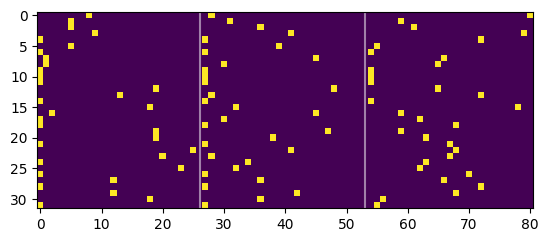

In [58]:
plt.imshow(F.one_hot(xs, vocab_size).view(xs.shape[0], -1));  # (32, 81)
draw_grid = lambda x: plt.axvline(x=x, color='white', alpha=0.5);
draw_grid(26)
draw_grid(53)

# Exercise 2 - Fast loss
This exercise uses the torch [cross_entropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss) function as the loss in one step, then back prop the loss function in one go.

From the pytorch man page:$L={\{l_1, l_2, ..., l_N\}}^{\mathrm{T}}$
$$l_n = - w_{y_n} \log \frac{\exp(x_{n,y_n})}{\sum_{c=1}^C \exp(x_{n,c})}
\cdot \mathbb{1}\{y_n \not= \text{ignore\_index}\}
$$

Translating into our naming in the python code:
$$l_i = -log\dfrac{\exp(logits_{i, y_i})}{\sum_{j}\exp(logits_{i,j})}
$$
where $i\in [0, batch\_size), j\in [0, vocab\_size)$
$$Loss = \frac{1}{N}\sum_{i}^{N}l_i$$

Derivative: let's calculate $\frac{\delta l}{\delta logits_j}$ and $\frac{\delta l}{\delta logits_y}$, respectively. Let $s=logits$, for brievity.
hence,
$$l_i = -log\dfrac{e^{s_{y_i}}}{\sum_{j}e^{s_j}}
$$
## derivative
see [my blog](https://romenlaw.blogspot.com/2024/06/study-notes-of-simple-neuro-network.html) for working:

$$\frac{\delta l_i}{\delta s_j} = P_i = softmax(s) \\
\frac{\delta l_i}{\delta s_y} = P_i-1 = softmax(s)-1 \\
\therefore \frac{\delta Loss}{\delta s_j} = \frac{1}{N}\times P_i \\
\frac{\delta Loss}{\delta s_y} = \frac{1}{N}\times (P_i-1)
$$






In [59]:
loss_fast = F.cross_entropy(logits, ys)
print(loss_fast.item(), 'diff: ', (loss_fast - loss).item())

3.5082900524139404 diff:  4.76837158203125e-07


In [60]:
#dlogits = F.softmax(logits, dim=1)
#dlogits[range(batch_size), ys] -= 1
dlogits = F.softmax(logits, dim=1) - F.one_hot(ys, vocab_size)

dlogits = dlogits / batch_size
cmp('dlogits', dlogits, logits)

dlogits         | exact: False | approx: True  | maxdiff: 5.122274160385132e-09


In [61]:
F.one_hot(ys, vocab_size)[0], ys

(tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0]),
 tensor([12, 14,  8, 21,  8, 14, 12,  5,  9,  7,  3,  4,  5, 11,  5, 12,  9, 15,
         15, 12, 16,  1,  0,  9, 15,  0,  1,  9, 15, 20,  5, 12]))

In [62]:
probs=F.softmax(logits, 1)
probs[0], probs[0].sum(), probs[0].max()

(tensor([0.0358, 0.0162, 0.0248, 0.0362, 0.0667, 0.0391, 0.0147, 0.1270, 0.0311,
         0.0959, 0.0074, 0.0117, 0.0738, 0.0272, 0.0494, 0.0693, 0.0127, 0.0159,
         0.0436, 0.0241, 0.0283, 0.0084, 0.0072, 0.0245, 0.0506, 0.0307, 0.0275],
        grad_fn=<SelectBackward0>),
 tensor(1., grad_fn=<SumBackward0>),
 tensor(0.1270, grad_fn=<MaxBackward1>))

In [63]:
(dlogits)[0]*batch_size, dlogits[0].sum()

(tensor([ 0.0358,  0.0162,  0.0248,  0.0362,  0.0667,  0.0391,  0.0147,  0.1270,
          0.0311,  0.0959,  0.0074,  0.0117, -0.9262,  0.0272,  0.0494,  0.0693,
          0.0127,  0.0159,  0.0436,  0.0241,  0.0283,  0.0084,  0.0072,  0.0245,
          0.0506,  0.0307,  0.0275], grad_fn=<MulBackward0>),
 tensor(-1.3970e-09, grad_fn=<SumBackward0>))

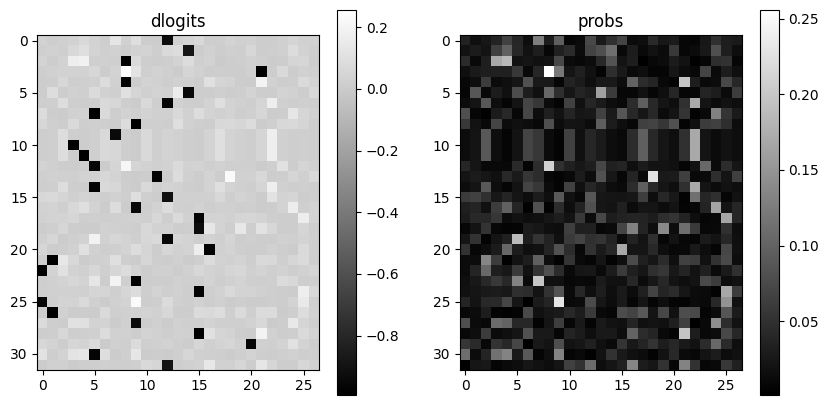

In [64]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
cx1 = ax1.imshow(dlogits.detach()*batch_size, cmap='gray')
ax1.set_title('dlogits')
fig.colorbar(cx1, ax=ax1)

cx2 = ax2.imshow((probs).detach(), cmap='gray')
ax2.set_title('probs')
fig.colorbar(cx2, ax=ax2)

# Exercise 3 - Fast Batch Norm
see [my blog](https://romenlaw.blogspot.com/2024/06/calculating-gradient-using-computation.html) for the analytical calculation.
<p><img src='https://camo.githubusercontent.com/5caa8bf914be33124a2d303f6bfa1ac9479d73bddfac7115f4f80fe80a6bdb00/68747470733a2f2f6b686172736869742e6769746875622e696f2f696d672f62617463685f6e6f726d616c697a6174696f6e2e706e67'/>
</p>

mapping to our variable names: x is h_prebn, y is h_preact_fast

find dh_prebn, given h_preact_fast

##1 dL/dxi
$$\frac{\delta L}{\delta \hat x_i}=\frac{\delta L}{\delta y_i} \times \frac{\delta y_i}{\delta \hat x_i} = \frac{\delta L}{\delta y_i} \times \gamma
$$
##2 dL/dVar
$\sigma^2$ acts on every row of $\hat x_i$ (which has 32 rows), so the back prop arrows into $\sigma^2$ needs to be summed up for each row.
$$\frac{\delta L}{\delta \sigma^2} = \sum_i^N \left(\frac{\delta L}{\delta \hat x_i} \times \frac{\delta \hat x_i}{\delta \sigma^2}\right) \\
= \sum_i^N \left[\frac{\delta L}{\delta y_i} \gamma (-\frac{1}{2})(x_i-\mu)(\sigma^2+\epsilon)^{-3/2}\right] \\
= -\frac{1}{2}\sum_i^N \left[\frac{\delta L}{\delta y_i} \gamma (x_i-\mu)(\sigma^2+\epsilon)^{-3/2}\right]
$$
##3 dL/dμ
There are two paths from L to μ: from $\hat x_i$, and from $\sigma^2$

Similarly, $\mu$ acts on every row of x, so the back prop arrows into $\mu$ needs to be summed up for each row.

$$\frac{\delta L}{\delta \mu} = \sum_i^N\left(\frac{\delta L}{\delta \hat x_i}\times\frac{\delta \hat x_i}{\delta \mu}\right) + \frac{\delta L}{\delta \sigma^2}\times\frac{\delta \sigma^2}{\delta \mu}
$$
now,
$$\frac{\delta \hat x_i}{\delta \mu} = -(\sigma^2+\epsilon)^{-1/2}
$$
$$\frac{\delta \sigma^2}{\delta \mu} = \frac{1}{N-1}\sum_i^N(2\mu-2x_i)\\
=\frac{2}{N-1}\sum_i^N(\mu-x_i) \\
=\frac{2}{N-1} (\sum_i^N \mu - \sum_i^N x_i) \\
=\frac{2}{N-1} \times 0 = 0
$$
$$\therefore \frac{\delta L}{\delta \mu} = \sum_i^N\left(\frac{\delta L}{\delta \hat x_i}\times\frac{\delta \hat x_i}{\delta \mu}\right)+0\\
=-\sum_i^N \left(\frac{\delta L}{\delta y_i}\gamma(\sigma^2+\epsilon)^{-1/2}\right)
$$
##4 dL/dxi
There are 3 paths to xi
1. from $\hat x_i$ - this is one per row (32 of them)
2. from $\sigma^2$
3. from $\mu$

so we need to add them up:
$$
\frac{\delta L}{\delta x_i} = \frac{\delta L}{\delta \hat x_i}\frac{\delta \hat x_i}{\delta x_i} + \frac{\delta L}{\delta \sigma^2}\frac{\delta \sigma^2}{\delta x_i} + \frac{\delta L}{\delta \mu}\frac{\delta \mu}{\delta x_i}
$$
Now, let's do the building blocks one by one:
$$\frac{\delta \hat x_i}{\delta x_i} = \frac{\delta}{\delta x_i}\left( \frac{x_i-\mu}{\sqrt{\sigma^2+\epsilon}}\right) = (\sigma^2+\epsilon)^{-1/2}
$$
$$\frac{\delta \sigma^2}{\delta x_i}=\frac{\delta}{\delta x_i}\left( \frac{1}{N-1}\sum_i^N(x_i-\mu)^2\right)=\frac{2}{N-1}(x_i-\mu), \quad \text{notice that unlike }\frac{\delta \sigma^2}{\delta \mu},\text{ this is not 0 because we are only doing it for one row of x (which has 32 rows).}
$$
$$\frac{\delta \mu}{\delta x_i}=\frac{\delta}{\delta x_i}\left(\frac{1}{N}\sum_i^N x_i \right) = \frac{1}{N}\sum_i^N 1 = \frac{1}{N}
$$
putting it together: notice the renaming of i into j for all the sums to distinguish it from the xi (i.e. j denotes the for loop for all rows in the mini batch).
$$\frac{\delta L}{\delta x_i}
=\frac{\delta L}{\delta y_i}\gamma(\sigma^2+\epsilon)^{-1/2} \\
-\frac{1}{2}\sum_j^N \left[\frac{\delta L}{\delta y_j} \gamma (x_j-\mu)(\sigma^2+\epsilon)^{-3/2}\right]\frac{2}{N-1}(x_i-\mu) \\
-\frac{1}{N}\sum_j^N \left(\frac{\delta L}{\delta y_j}\gamma(\sigma^2+\epsilon)^{-1/2}\right)
$$
Notice that $\hat x_i = (x_i-\mu)(\sigma^2+\epsilon)^{-\frac{1}{2}}$, substitue into the 2nd term:
$$\frac{\delta L}{\delta x_i}
=\gamma(\sigma^2+\epsilon)^{-\frac{1}{2}}\frac{\delta L}{\delta y_i} \\
-\frac{(\sigma^2+\epsilon)^{-\frac{1}{2}}}{N}\sum_j^N \left[\frac{\delta L}{\delta y_j} \gamma \hat x_j\right]\frac{1}{N-1}\hat x_i \\
-(\sigma^2+\epsilon)^{-1/2}\sum_j^N \left(\frac{\delta L}{\delta y_j}\gamma\right) \\
=\frac{\gamma(\sigma^2+\epsilon)^{-1/2}}{N}\left[N\frac{\delta L}{\delta y_i}
-\frac{N}{N-1}\hat x_i\sum_j^N \left(\frac{\delta L}{\delta y_j} \hat x_j\right) - \sum_j^N \left(\frac{\delta L}{\delta y_j}\right)
\right]
$$

In [65]:
hpreact_fast = bn_gamma * (h_prebn - h_prebn.mean(0, keepdim=True)) / torch.sqrt(h_prebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bn_bias
print('max diff:', (hpreact_fast - h_preact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


In [66]:
n=batch_size
dh_prebn = bn_gamma*bn_varinv/n*( n*dh_preact - n/(n-1)*x_hat*(dh_preact*x_hat).sum(0) - dh_preact.sum(0))
cmp('dh_prebn', dh_prebn, h_prebn)

dh_prebn        | exact: False | approx: True  | maxdiff: 9.313225746154785e-10


# Exercise 4 - putting it together

## MLP initialisation

In [84]:
embed_dim = 10
hidden_dim = 200

g = torch.Generator().manual_seed(20240827)
C = torch.randn((vocab_size, embed_dim),  generator=g)

# hidden layer
fan_in = embed_dim*block_size # we concat multiple C's to feed into hidden layer
W1 = torch.randn((fan_in, hidden_dim), generator=g) * (5/3 / fan_in**0.5)
b1 = torch.randn(hidden_dim,           generator=g) * 0.1 # experiment
# output layer
W2 = torch.randn((hidden_dim, vocab_size), generator=g) * 0.1
b2 = torch.randn(vocab_size,               generator=g) * 0.1 # experiment with non-zero

# batch normalisation 1D layer placed after hidden layer, hence dim=hidden_dim
bn_gamma = torch.randn((1, hidden_dim),    generator=g) * 0.1 + 1.0
bn_beta = torch.randn((1, hidden_dim),     generator=g) * 0.1
bn_running_mean = torch.zeros((1, hidden_dim))
bn_running_var = torch.ones((1, hidden_dim))

# the above are initialised with non-standard values to magnify any incorrect values

parameters = [C, W1, b1, W2, b2, bn_gamma, bn_beta]
print('total params: ', sum([p.nelement() for p in parameters]))
for p in parameters:
  p.requires_grad = True

total params:  12297


## training

In [85]:
max_steps = 200000
batch_size = 32
n = batch_size
lossi = []
with torch.no_grad():
  for i in range(max_steps):

    # construct mini-batch:
    # generate a list of random indices, length of list if batch_size
    ix = torch.randint(low=0, high=X_train.shape[0], size=(batch_size,), generator=g)
    xs = X_train[ix]  # (batch_size, block_size)
    ys = Y_train[ix]  # (batch_size)

    ##################################
    # forward pass (expanded version)
    ##################################
    # embedding ---------------------------
    emb = C[xs] # (batch_size, block_size, hidden_dim)
    embcat = emb.view(emb.shape[0], -1)

    # hidden layer ------------------------
    h_prebn = embcat @ W1 + b1 # (batch_size, hidden_dim)

    # BN layer (expended version) ----------------------------
    bn_mean = h_prebn.mean(dim=0, keepdim=True)
    bn_var = h_prebn.var(dim=0, keepdim=True, unbiased=True)
    bn_varinv = (bn_var + 1e-5)**-0.5  # 1/sqrt(var+eps)
    x_hat = (h_prebn - bn_mean) * bn_varinv
    h_preact = bn_gamma * x_hat + bn_beta
    # with torch.no_grad():
    #   bn_running_mean = 0.999 * bn_running_mean + 0.001 * bn_mean
    #   bn_running_var = 0.999 * bn_running_var + 0.001 * bn_var

    # Non-linearity ----------------------
    h = torch.tanh(h_preact)  # (batch_size, hidden_dim)

    # output layer -----------------------
    logits = h @ W2 + b2 # (hidden_dim, vocab_size)
    # loss function (extended version) ----------------------
    loss = F.cross_entropy(logits, ys)

    ################
    # backward pass - using manual calculation instead of loss.backward()
    ################
    dC, dW1, db1, dW2, db2, dbn_gamma, dbn_beta = None, None, None, None, None, None, None

    # since we used the cross_entropy function, need to used the fast grad from exercise 2
    dlogits = F.softmax(logits, dim=1)
    dlogits[range(n), ys] -= 1
    dlogits /= n

    dW2 = h.T @ dlogits
    db2 = dlogits.sum(dim=0)
    dh = dlogits @ W2.T

    dh_preact = (1.0- h**2) * dh

    dh_prebn = bn_gamma*bn_varinv/n*( n*dh_preact - n/(n-1)*x_hat*(dh_preact*x_hat).sum(0) - dh_preact.sum(0))
    dbn_gamma = (dh_preact * x_hat).sum(0, keepdim=True)
    dbn_beta = dh_preact.sum(0, keepdim=True)

    dW1 = embcat.T @ dh_prebn
    db1 = dh_prebn.sum(dim=0)
    dembcat = dh_prebn @ W1.T

    demb = dembcat.view(emb.shape)
    dC = torch.einsum('abc,abg->cg', F.one_hot(xs, vocab_size).float(), demb)
    # dC = torch.zeros_like(C)
    # for k in range(xs.shape[0]):
    #   for j in range(xs.shape[1]):
    #     ix = xs[k,j]
    #     dC[ix] += demb[k,j]

    grads = [dC, dW1, db1, dW2, db2, dbn_gamma, dbn_beta]

    ###############
    # update
    ###############
    lr = 0.1 if i<100000 else 0.01
    for p, grad in zip(parameters, grads):
      #p.data += -lr * p.grad # using pyTorch grads
      p.data += -lr * grad # using manually calculated grads

    # tracking
    lossi.append(loss)
    if i%10000 == 0:
      print('%6d/%7d %2.10f' % (i, max_steps, loss))

    # if i>1000:
    # break
  print('%6d/%7d %2.10f' % (i, max_steps, loss))

     0/ 200000 3.6914379597
 10000/ 200000 1.9552644491
 20000/ 200000 2.2685542107
 30000/ 200000 1.9765737057
 40000/ 200000 2.1635541916
 50000/ 200000 2.3569927216
 60000/ 200000 2.6716287136
 70000/ 200000 2.3283567429
 80000/ 200000 2.2069654465
 90000/ 200000 2.1901471615
100000/ 200000 2.0944044590
110000/ 200000 2.1021707058
120000/ 200000 1.9481284618
130000/ 200000 2.1118209362
140000/ 200000 2.0295965672
150000/ 200000 1.7541403770
160000/ 200000 1.9991391897
170000/ 200000 1.9426642656
180000/ 200000 2.0940511227
190000/ 200000 2.2560067177
199999/ 200000 2.0233426094


In [ ]:
### for debugging

# for t in [ logits, h, h_preact,
#         x_hat, bn_varinv, bn_var, bn_diff2, bn_diff, bn_mean,
#         bn_gamma, bn_beta,
#         h_prebn, embcat, emb ]:
#   t.retain_grad()
# loss.backward()
# cmp('dlogits', dlogits, logits)
# cmp('dW2', dW2, W2)
# cmp('db2', db2, b2)
# cmp('dh', dh, h)
# cmp('dh_preact', dh_preact, h_preact)
# cmp('dh_prebn', dh_prebn, h_prebn)
# cmp('dbn_gamma', dbn_gamma, bn_gamma)
# cmp('dbn_beta',dbn_beta, bn_beta)
# cmp('dW1', dW1, W1)
# cmp('db1', db1, b1)
# cmp('dembcat', dembcat, embcat)
# cmp('demb', demb, emb)
# cmp('dC', dC, C)

In [86]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[X_train]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnvar = hpreact.var(0, keepdim=True, unbiased=True)

## validate

In [87]:
@torch.no_grad()
def split_loss(split):
  """Returns the required split of the samples and labels
  split - one of 'train', 'val', 'test'
  """
  x,y={
      'train': (X_train, Y_train),
      'val': (X_dev, Y_dev),
      'test': (X_test, Y_test)
  }[split]
  emb = C[x] # (N=Num of samples, block_size, emb_dim)
  h_preact = emb.view(-1, embed_dim*block_size) @ W1 + b1
  h_preact = bn_gamma * (h_preact - bnmean) * (bnvar + 1e-5)**-0.5 + bn_beta

  h = torch.tanh( h_preact ) # (N, hidden_dim)

  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0743484497070312
val 2.1163837909698486


The loss is 2.07-2.11, comparable to the previous makemore notebook using various methods.

In [92]:
# sample from the model
g = torch.Generator().manual_seed(20240827+10) # diff seed from training

for _ in range(20): # let's generate 20 samples
  out=[]
  context=[0]*block_size # start with '...'

  while True:
    emb = C[ torch.tensor([context]) ]  # embedding of the 3-letters (context)
    h_preact = emb.view(emb.shape[0], -1) @ W1 + b1
    h_preact = bn_gamma * (h_preact - bnmean) / (bnvar+1e-5)**0.5 + bn_beta

    h = torch.tanh(h_preact)

    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    context = context[1:]+[ix]  # shift the context by 1
    out.append(ix)
    if ix==0: # if generated a dot, then it's end of word
      break
  print (''.join(itos[i] for i in out))

adi.
jetti.
izren.
ise.
maret.
ken.
eson.
sevveros.
shokybora.
oriaman.
eprick.
briaha.
chant.
calionnaleiah.
kyni.
cobie.
agrenabi.
elyn.
mani.
katkalizoylin.
